In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [127]:
df = pd.read_csv("data.csv")

# Sector-wise profitability

/var/folders/y8/lh75q07s5v3483_pb255smrw0000gn/T/ipykernel_99475/3879008057.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sector_profitability = sector_profitability.applymap(format_large_numbers)


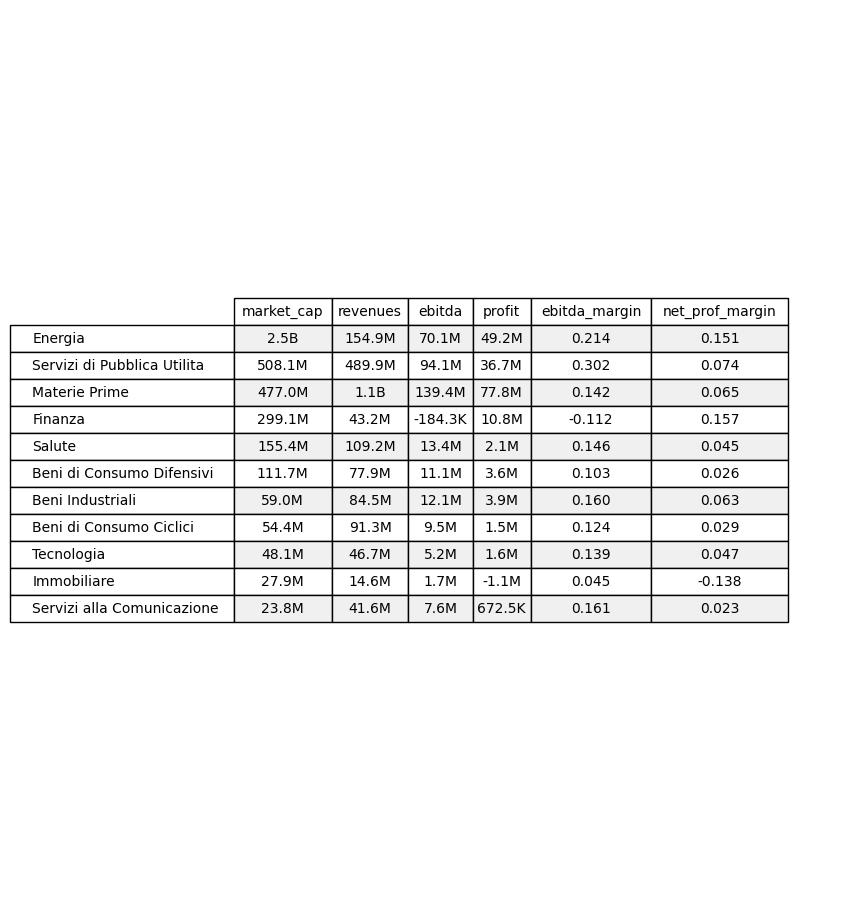

In [128]:
# Identifying key financial metrics
profitability_metrics = [
    "market_cap",
    "revenues",
    "ebitda",
    "profit",
    "ebitda_margin",
    "net_prof_margin",
]

# Group by sector and calculate median values for key profitability metrics
sector_profitability = df.groupby("sector")[profitability_metrics].median()


# Sort by median market cap in descending order
sector_profitability = sector_profitability.sort_values(
    by="market_cap", ascending=False
)
# Convert large numbers to a readable format (e.g., millions or billions)
def format_large_numbers(value):
    if value >= 1e9:
        return f"{value/1e9:.1f}B"
    elif abs(value) >= 1e6:
        return f"{value/1e6:.1f}M"
    elif abs(value) >= 1e3:
        return f"{value/1e3:.1f}K"
    else:
        return f"{value:.3f}"


# Apply formatting to numeric columns
sector_profitability = sector_profitability.applymap(format_large_numbers)

# Plot the table and save it as a PDF
fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4 size in inches (8.27 x 11.69)
ax.axis("tight")
ax.axis("off")

# Create table
table = ax.table(
    cellText=sector_profitability.values,
    colLabels=sector_profitability.columns,
    rowLabels=sector_profitability.index,
    cellLoc="center",
    loc="center",
)

# Adjust table styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3, 4, 5])

# **Increase row height & add visible grid lines for better readability**
for (i, j), cell in table.get_celld().items():
    cell.set_height(0.03)  

row_count = len(sector_profitability)
for i in range(row_count):
    for j in range(len(profitability_metrics)):  
        cell = table[i + 1, j]  
        if i % 2 == 0:
            cell.set_facecolor("#f0f0f0")  
        else:
            cell.set_facecolor("#ffffff")  
        cell.set_edgecolor("black")  


# MinMax Rescaling

In [129]:
# Selecting numerical columns
num_cols = df.select_dtypes(include=["number"]).columns

# Identifying percentage-based columns (these should not be rescaled by market cap)
percentage_columns = [
    "p_e",
    "ebitda_margin",
    "net_prof_margin",
    "shf_liabilities",
    "roa",
    "roe",
    "ros",
    "debt_equity",
]  # Adjust based on your dataset

# Identifying non-percentage columns to be scaled by market cap
non_percentage_cols = [
    col for col in num_cols if col not in percentage_columns
]

# Rescale non-percentage columns by market capitalization
for col in non_percentage_cols:
    df[col] = df[col] / df["market_cap"]

# Applying Min-Max Scaling
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df = df.drop(columns=["market_cap"])

# Correlation Matrix

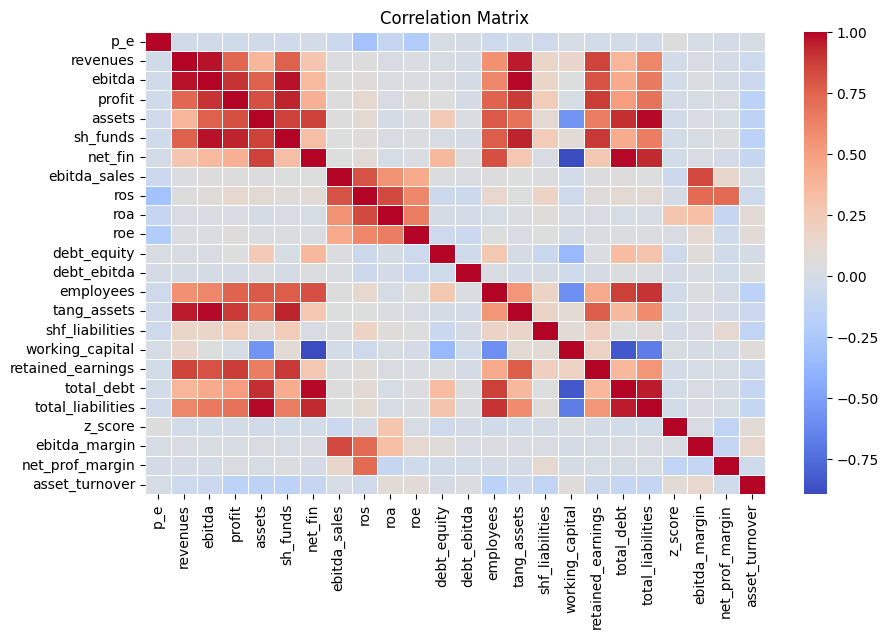

In [132]:
num_cols = df.select_dtypes(include=["number"]).columns
# Compute correlation matrix
correlation_matrix = df[num_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Draw the heatmap
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=0.5)

# Add title
plt.title("Correlation Matrix")

# Show plot
plt.show()

## Divided per sector

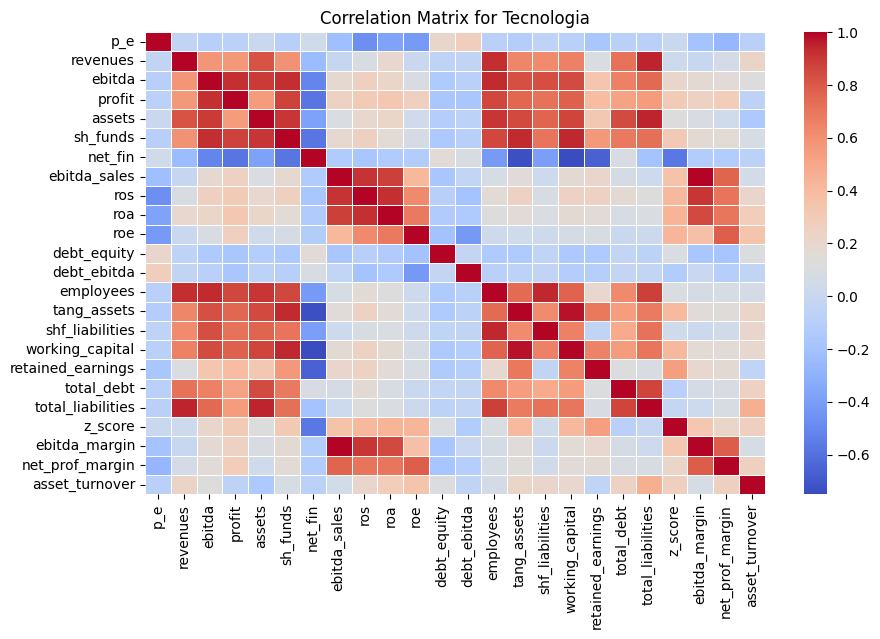

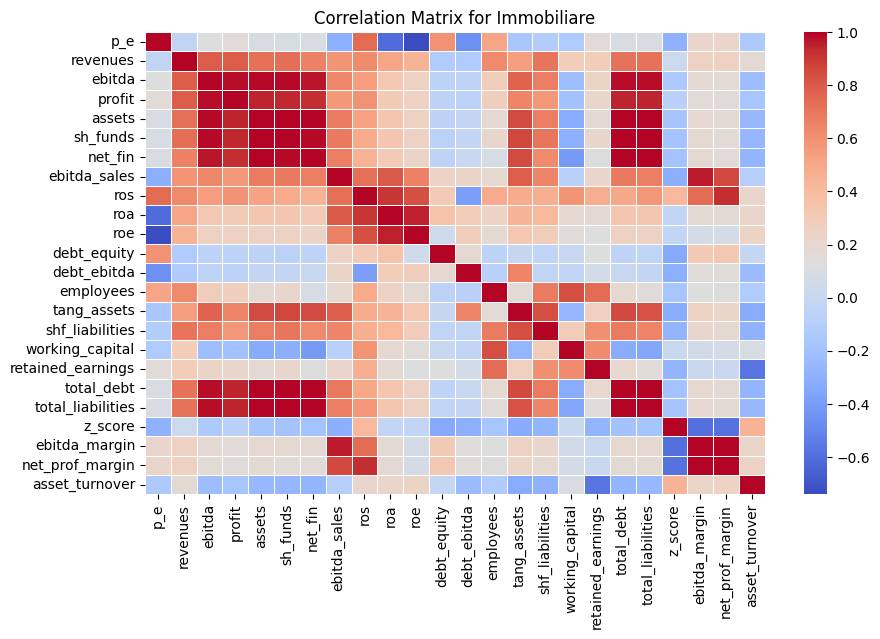

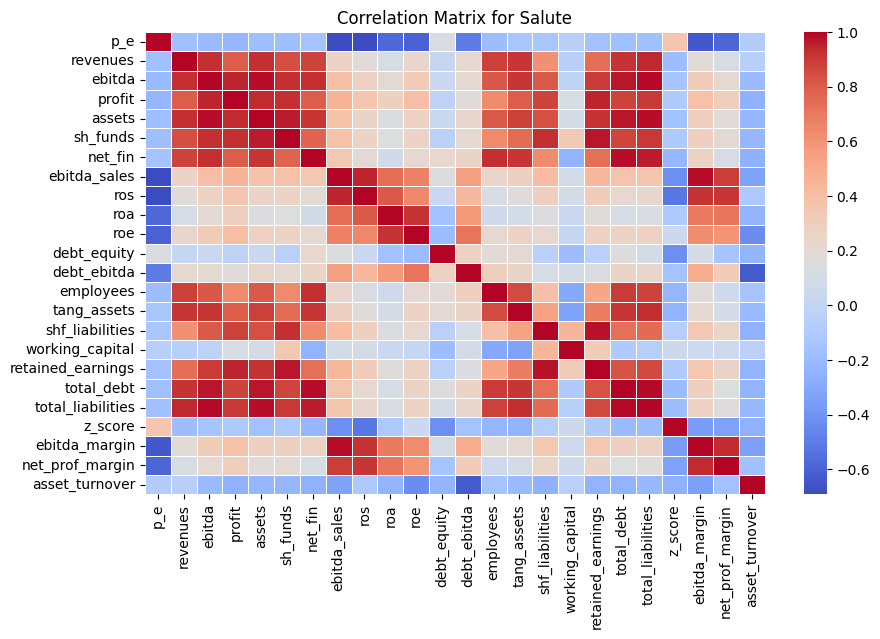

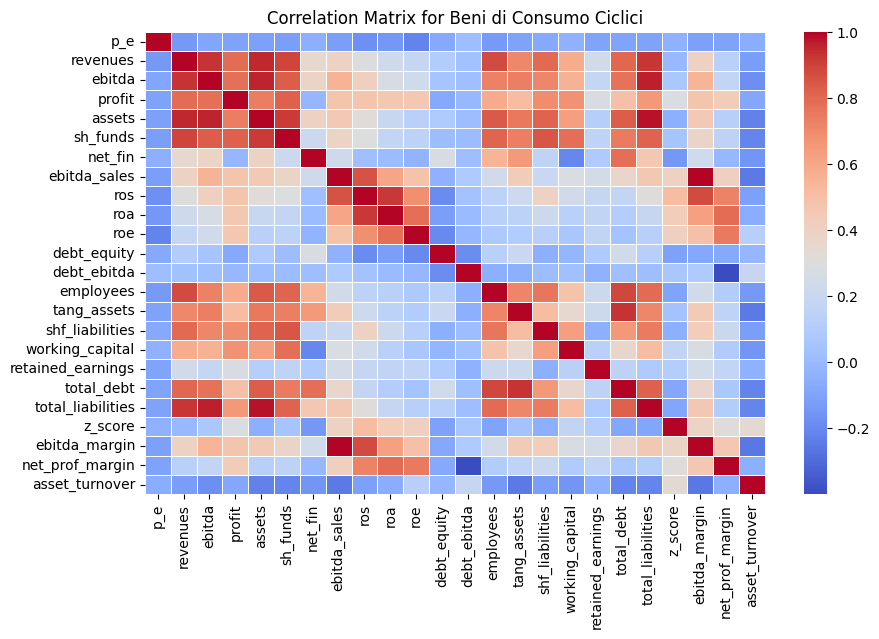

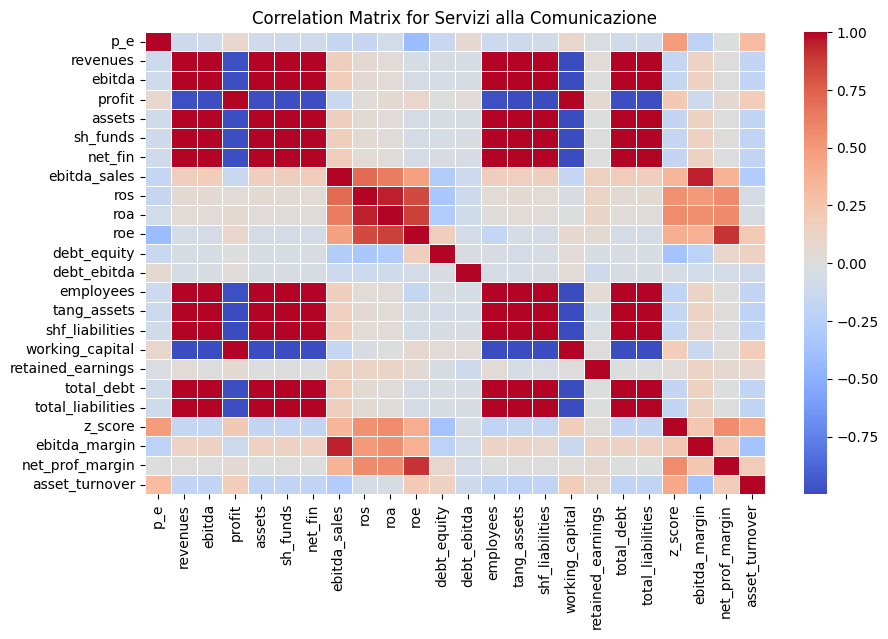

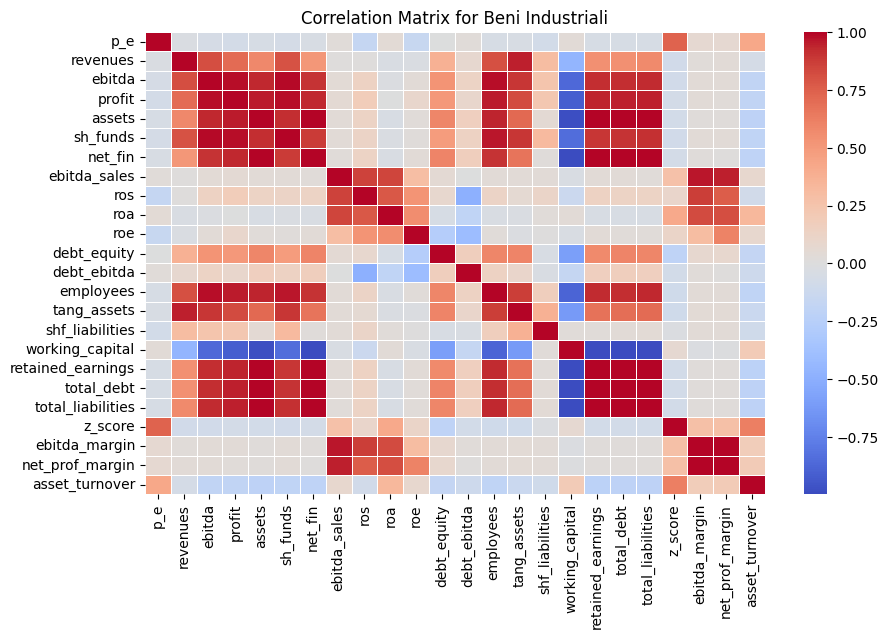

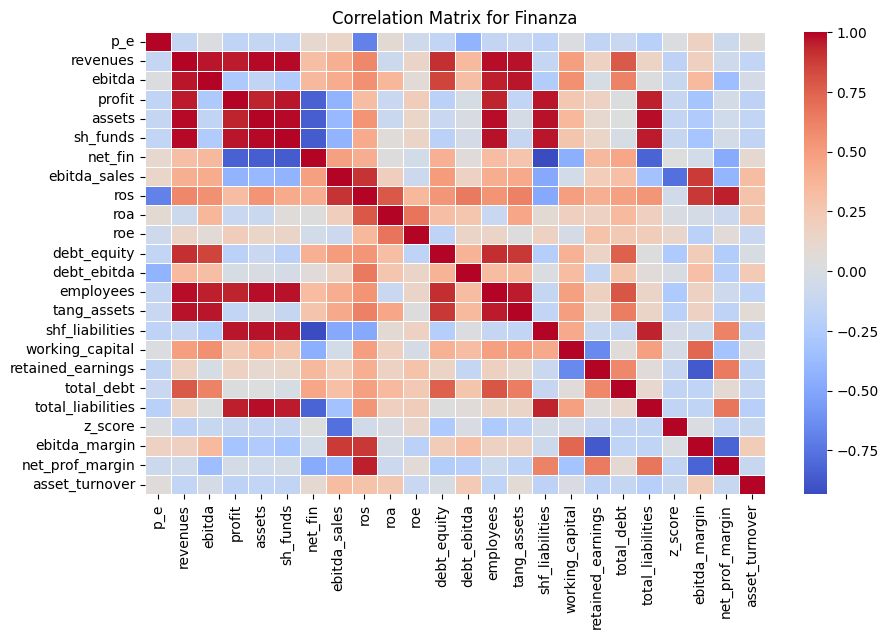

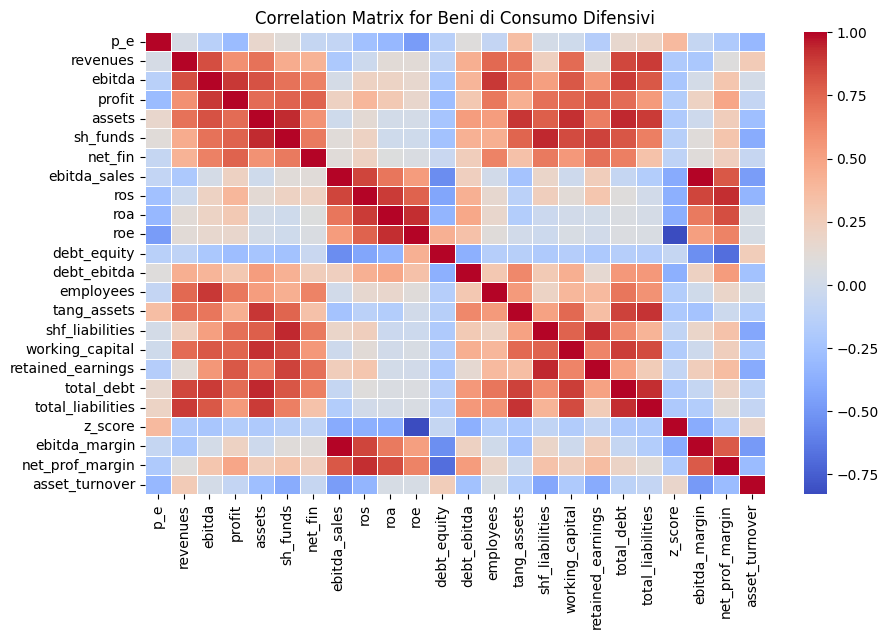

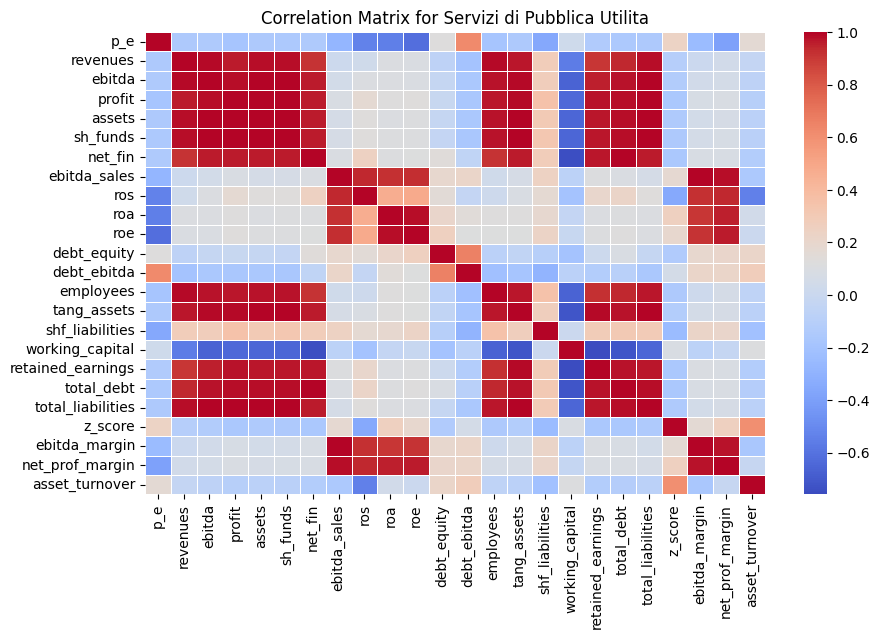

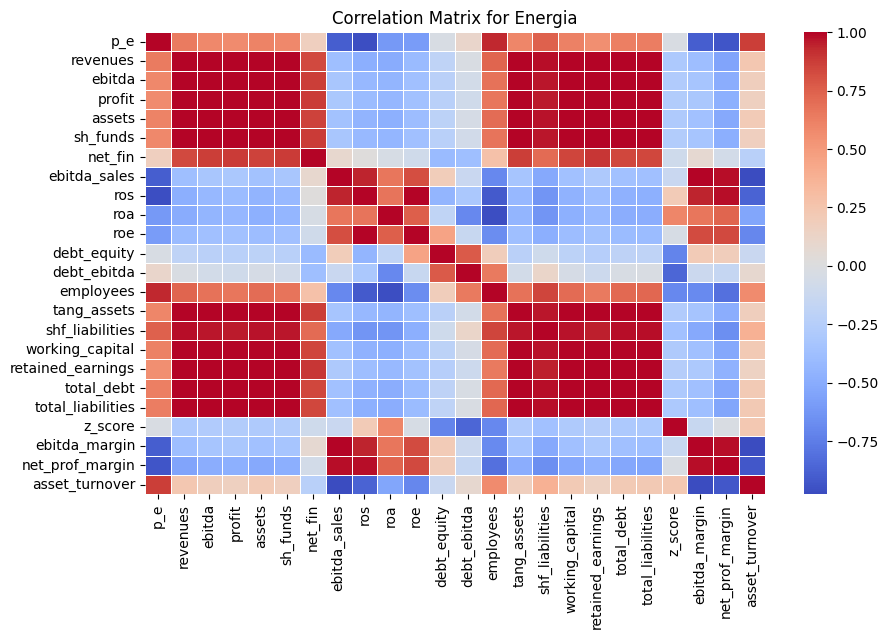

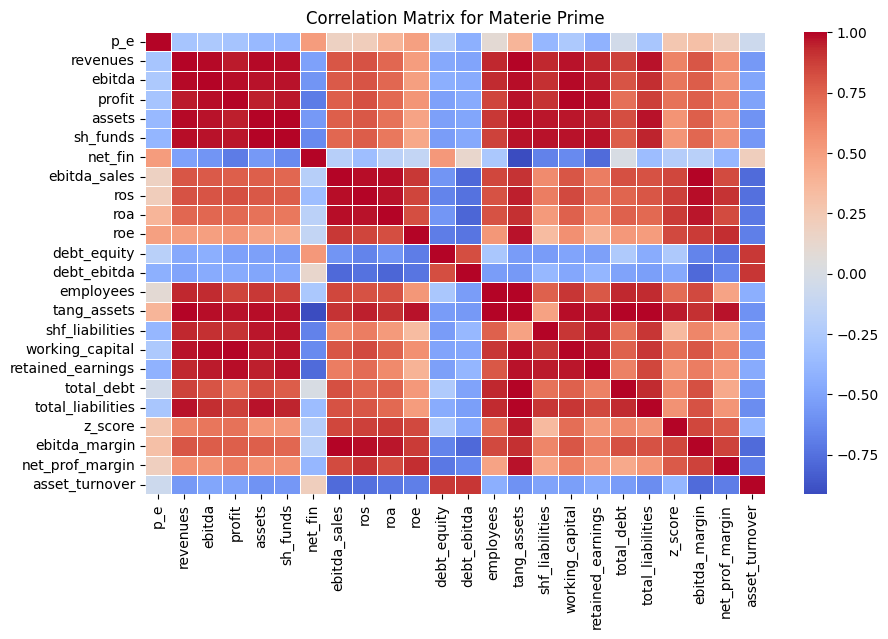

In [131]:
# Get unique sectors
sectors = df["sector"].unique()

# Create correlation matrix for each sector and plot heatmap
for sector in sectors:
    df_sector = df[df["sector"] == sector]
    if df_sector.size == 0:
        continue

    # Compute correlation matrix (excluding categorical columns)
    correlation_matrix = df_sector[num_cols].corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Draw the heatmap
    sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=0.5)

    # Add title
    plt.title(f"Correlation Matrix for {sector}")

    # Show plot
    plt.show()